# Validation: Forecasting Held-Out Data

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* holds-out the final few days of the data, and see's if they can be predicted. 

The way I propose doing this is holding out the confirmed observations for the final three days of the day for every country, and then plotting it for validation. This effectively changes the output model. 

In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   .. mean  .. max
 0 Gatherings limited to                      0.000 .. 0.177 .. 0.982
 1 Business suspended                         0.000 .. 0.273 .. 1.000
 2 Schools and universities closed            0.000 .. 0.361 .. 1.000
 3 General curfew                             0.000 .. 0.167 .. 1.000
 4 Healthcare specialisation                  0.000 .. 0.020 .. 0.429
 5 Phone line                                 0.000 .. 0.032 .. 1.000
 6 Asymptomatic contact isolation             0.000 .. 0.053 .. 1.000


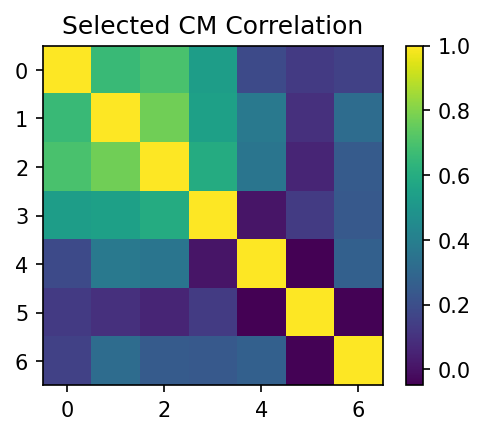

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}


['AT', 'BE', 'CH', 'CZ', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IS', 'NL', 'NO', 'PL', 'PT', 'SE', 'SI', 'SK']
('AT', 'BE', 'CH', 'CZ', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IS', 'NL', 'NO', 'PL', 'PT', 'SE', 'SI', 'SK')


In [223]:
regions = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "FI", "NO", "SE", "SI", "SK"]
features = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line', 'Asymptomatic contact isolation']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

In [323]:
with cm_effect.models.CMModelV2(data) as model2:
    model2.build_reduction_lognorm()
    model2.build_rates()
    model2.build_heldout_days_output_model(3)

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [324]:
model2.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__             9.69
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
HeldoutDays_log__            -0.17
Observed                 -13857.06
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HeldoutDays, Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
INFO:pymc3:NUTS: [HeldoutDays, Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [07:14<00:00, 11.50draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


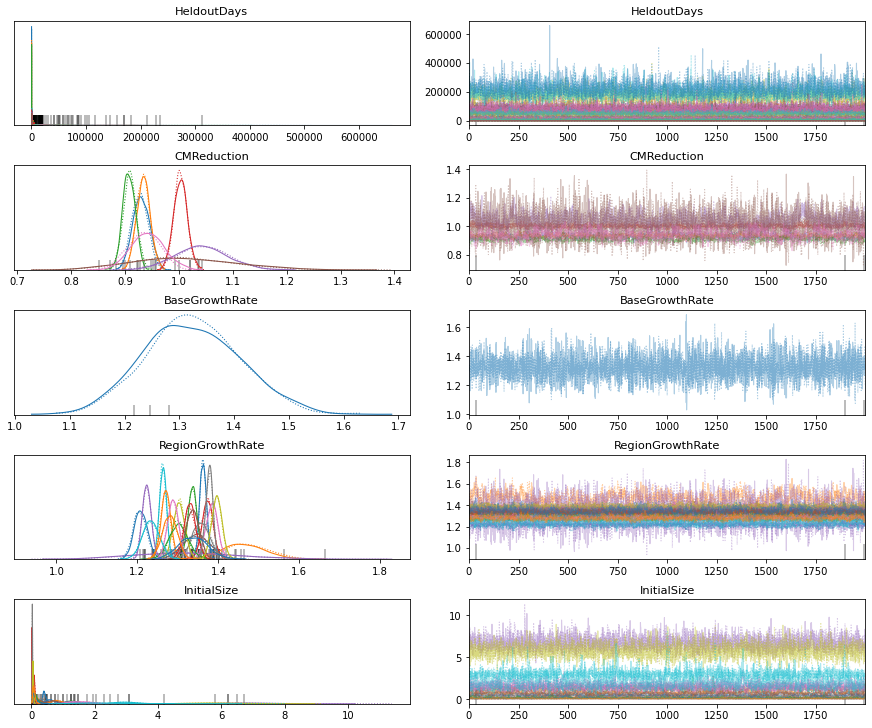

In [325]:
_ = model2.plot_traces()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


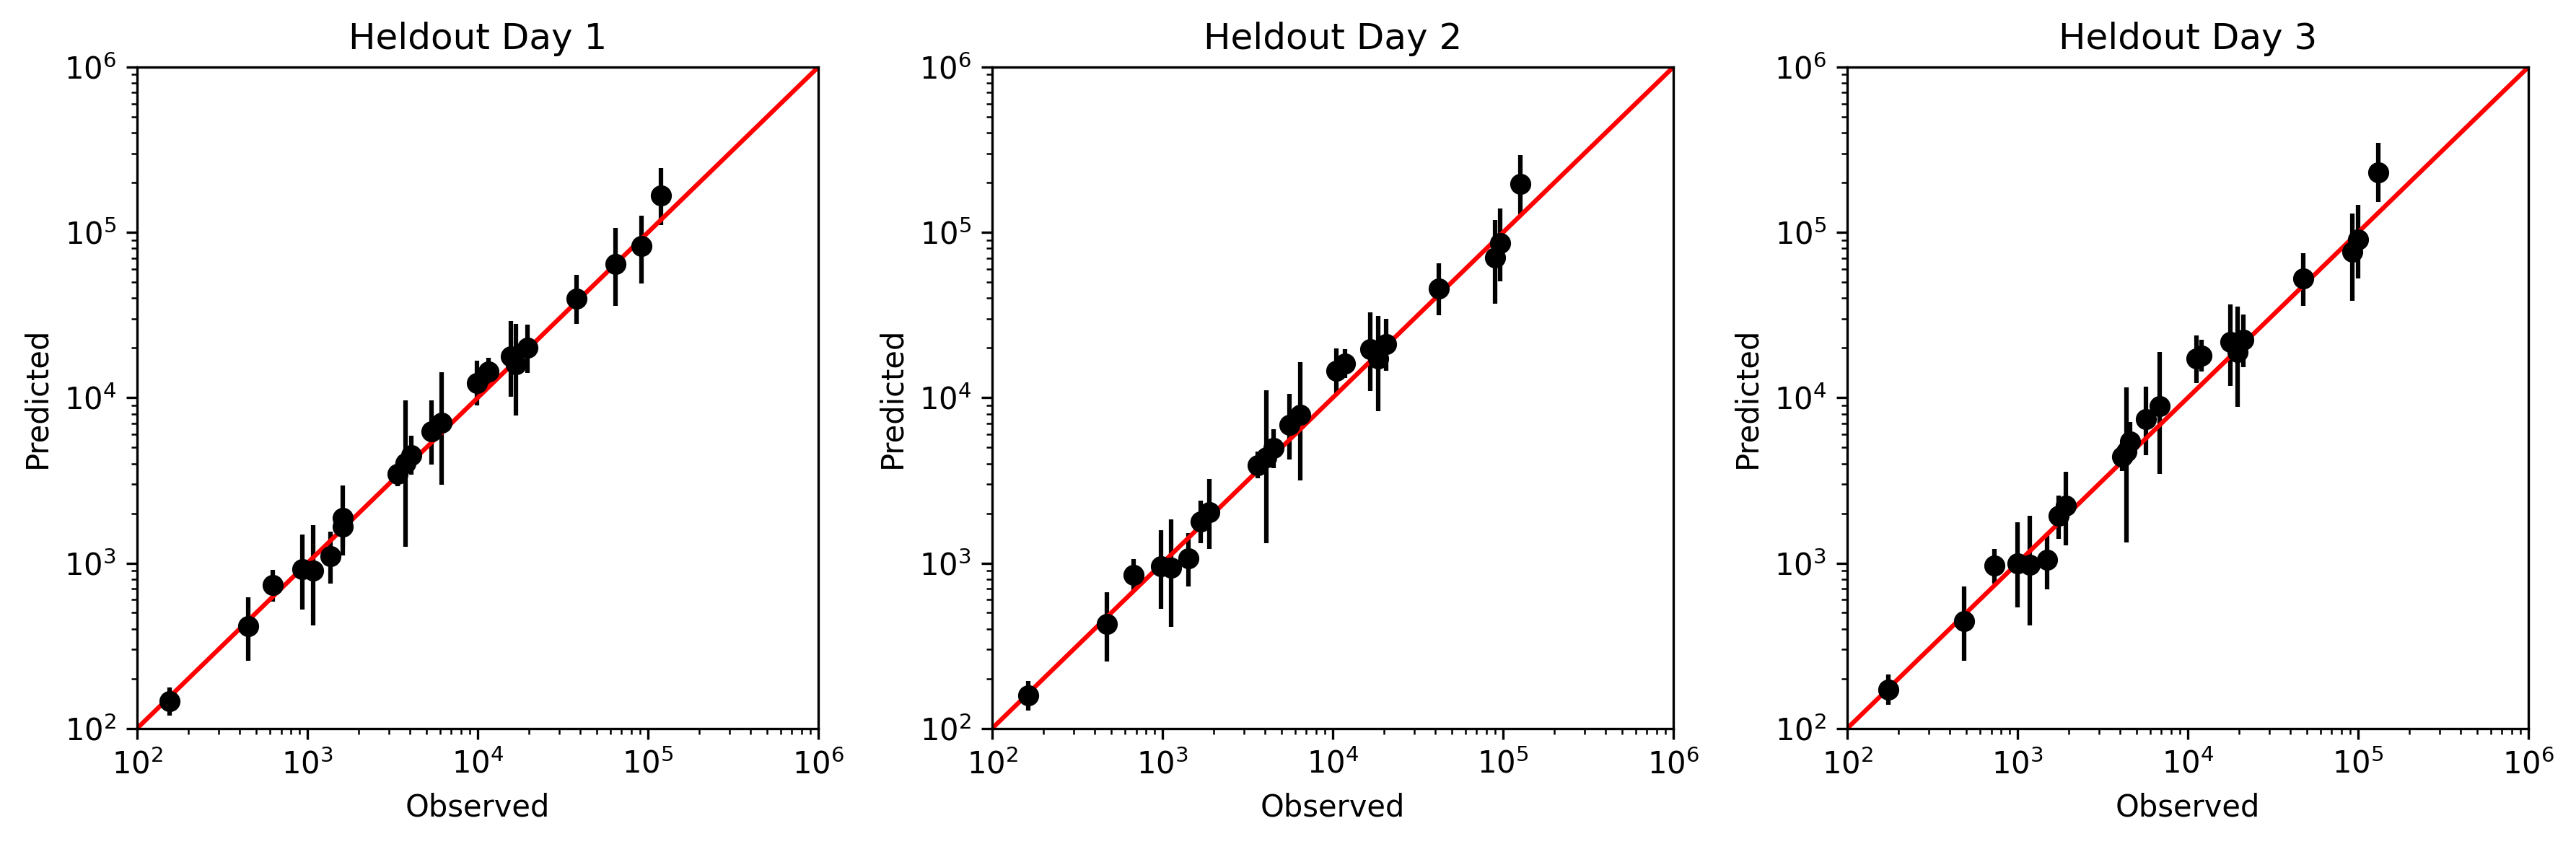

In [330]:
model2.heldout_days_validation_plot()